In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt

In [120]:
alex = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
alex.classifier[1] = nn.Linear(9216,4096)
alex.classifier[4] = nn.Linear(4096,1024)
alex.classifier[6] = nn.Linear(1024,10)

class LeNet(nn.Module):

    def __init__(self, act = F.tanh):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6 * 3, 5)
        self.conv2 = nn.Conv2d(6 * 3, 16 * 3, 5)
        self.f1 = nn.Linear(16 * 5 * 5 * 3, 120 * 3)
        self.f2 = nn.Linear(120 * 3, 84 * 3)
        self.f3 = nn.Linear(84 * 3, 10)
        self.act = act

    def forward(self, x):
        x = F.max_pool2d(self.act(self.conv1(x)), (2, 2))
        x = F.max_pool2d(self.act(self.conv2(x)), 2)
        x = x.view(-1, 1200)
        x = self.act(self.f1(x))
        x = self.act(self.f2(x))
        x = self.f3(x)
        return x



# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

#for  lenet:
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=0)

# Initialize the AlexNet model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg19 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)
googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
#net = vgg19.to(device)
#net = LeNet(F.relu).to(device)
#net = LeNet(F.sigmoid).to(device)
#net = LeNet(F.tanh).to(device)
#net = alex.to(device)
net = googlenet.to(device)

print('start')
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

losshist = []
val_list = []
acc_list = []
conf_mat = []
x = time.time()
# Train the model
for epoch in range(10):
    net.train()
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*inputs.size(0)
        #loss_histories[model_name].append(loss.item())

        #if i % 200 == 199:
            #print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            #running_loss = 0.0
    train_loss = train_loss/len(trainloader.dataset)
    losshist.append(train_loss)
    print(f"Epoch [{epoch+1}/{10}]\t Loss: {train_loss:.4f}")    
    
    net.eval()
    # accuracy
    correct = 0
    total = 0
    # validation loss 
    val_loss = 0.0
    batch_count = 0
    conf = np.zeros((10, 10)) # 10*10 since 10 outputs
    with torch.no_grad():
        for i, data in enumerate(testloader,0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            for x, y in zip(predicted, labels):
                conf[x][y] += 1
            # accuracy
            correct += (predicted == labels).sum().item()
            # Compute loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            batch_count += 1

    # calcualte loss and save
    avg_val_loss = val_loss / batch_count
    val_list.append(avg_val_loss)
    # save accuracy to list
    acc_list.append(100.0 * correct / total)
    print('Accuracy on the test images: %.2f %%' % (100.0 * correct / total))
    for i, c in enumerate(conf):
        #print(' '.join(map(lambda x:"%6.0f" % x, list(c))))
        conf_mat.append(list(c))
t = time.time() - x
print(f'Finished, time: {t * 1000:.0f}ms loss: {train_loss}')
print(f'The best accuracy is: {max(acc_list):.3f}%')


Using cache found in C:\Users\31149/.cache\torch\hub\pytorch_vision_v0.6.0


Files already downloaded and verified
Files already downloaded and verified


Using cache found in C:\Users\31149/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\31149/.cache\torch\hub\pytorch_vision_v0.10.0


start
Epoch [1/10]	 Loss: 1.1084
Accuracy on the test images: 74.06 %
Epoch [2/10]	 Loss: 0.6118
Accuracy on the test images: 78.59 %
Epoch [3/10]	 Loss: 0.4734
Accuracy on the test images: 76.71 %
Epoch [4/10]	 Loss: 0.3821
Accuracy on the test images: 79.38 %
Epoch [5/10]	 Loss: 0.3246
Accuracy on the test images: 80.47 %
Epoch [6/10]	 Loss: 0.2711
Accuracy on the test images: 79.36 %
Epoch [7/10]	 Loss: 0.2150
Accuracy on the test images: 79.99 %
Epoch [8/10]	 Loss: 0.1955
Accuracy on the test images: 79.82 %
Epoch [9/10]	 Loss: 0.1698
Accuracy on the test images: 81.65 %
Epoch [10/10]	 Loss: 0.1428
Accuracy on the test images: 81.77 %
Finished, time: 1698840707072ms loss: 0.1428444625711441
The best accuracy is: 81.770%


In [121]:
print(f'The best accuracy is: {max(acc_list):.3f}%')
print("Maximum Index position: ",acc_list.index(max(acc_list))) 
print(f'Average loss: {train_loss:.3f}')

The best accuracy is: 81.770%
Maximum Index position:  9
Average loss: 0.143


In [122]:
max_index=acc_list.index(max(acc_list))
if acc_list.index(max(acc_list)) == 1:
    conf_mat_concat=conf_mat[0:10]
else:
    conf_mat_concat=conf_mat[(max_index-1)*10:max_index*10]

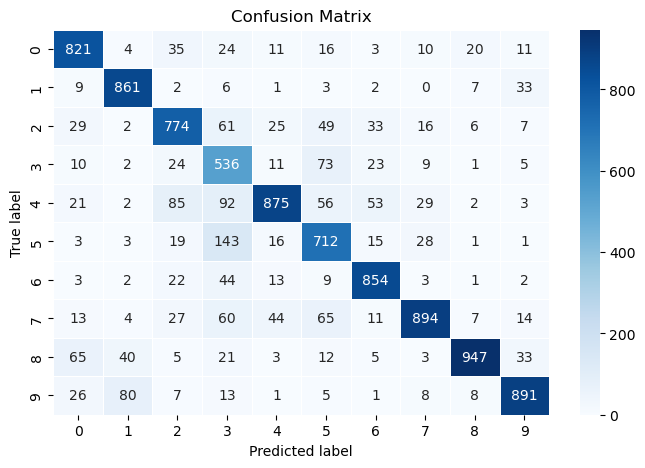

In [123]:
import seaborn as sns
# Plotting
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat_concat, annot=True, fmt=".0f", cmap='Blues', linewidths=.5, cbar=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.savefig('google_c_m')

In [124]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Convert to numpy array for easier indexing and manipulation
confusion_matrix_np = np.array(conf_mat_concat)

# Mask the diagonal with zeros, so you can ignore them when finding the maximum
np.fill_diagonal(confusion_matrix_np, 0)

# Get the index of the max mistake
row, col = np.unravel_index(confusion_matrix_np.argmax(), confusion_matrix_np.shape)

# Print the result
print(f"The most mistakes are between true class {classes[row]} and predicted class {classes[col]} with {confusion_matrix_np[row][col]} mistakes.")


The most mistakes are between true class dog and predicted class cat with 143.0 mistakes.


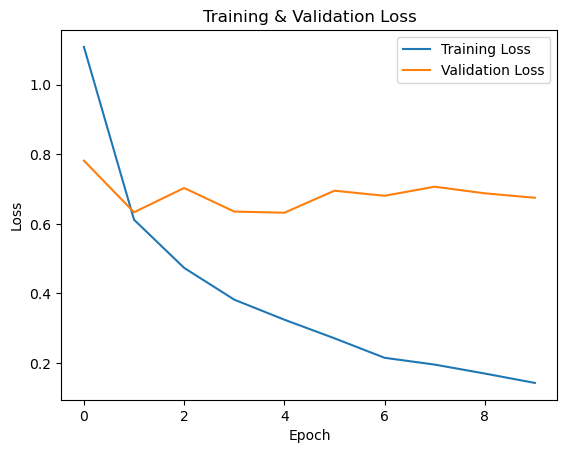

In [125]:
plt.plot(losshist,label='Training Loss')
plt.plot(val_list,label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Training & Validation Loss')
plt.savefig('google_loss.png')

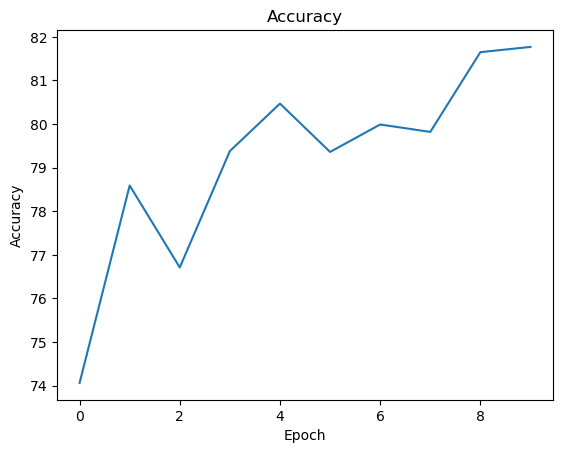

In [126]:
plt.plot(acc_list)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.savefig('google_acc.png')

Training vgg19...
[1,   200] loss: 0.269
[2,   200] loss: 0.209
[3,   200] loss: 0.173
[4,   200] loss: 0.168
[5,   200] loss: 0.295
[6,   200] loss: 0.196
[7,   200] loss: 0.124
[8,   200] loss: 0.144
[9,   200] loss: 0.160
[10,   200] loss: 0.127
Finished Training vgg19
Training LeNet_relu...
[1,   200] loss: 1.857
[2,   200] loss: 1.397
[3,   200] loss: 1.220
[4,   200] loss: 1.087
[5,   200] loss: 0.975
[6,   200] loss: 0.904
[7,   200] loss: 0.821
[8,   200] loss: 0.759
[9,   200] loss: 0.692
[10,   200] loss: 0.627
Finished Training LeNet_relu
Training LeNet_sigmoid...
[1,   200] loss: 2.292
[2,   200] loss: 1.930
[3,   200] loss: 1.757
[4,   200] loss: 1.622
[5,   200] loss: 1.542
[6,   200] loss: 1.469
[7,   200] loss: 1.410
[8,   200] loss: 1.363
[9,   200] loss: 1.313
[10,   200] loss: 1.283
Finished Training LeNet_sigmoid
Training LeNet_tanh...
[1,   200] loss: 1.655
[2,   200] loss: 1.263
[3,   200] loss: 1.095
[4,   200] loss: 1.013
[5,   200] loss: 0.911
[6,   200] loss: 

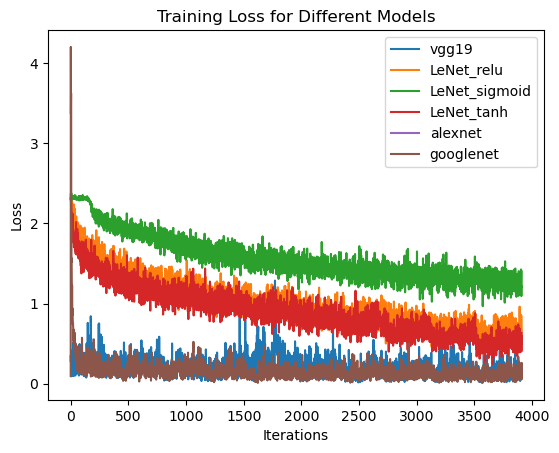

In [128]:
loss_histories = {
    'vgg19': [],
    'LeNet_relu': [],
    'LeNet_sigmoid': [],
    'LeNet_tanh': [],
    'alexnet': [],
    'googlenet': []
}

# List of models to train
models = {
    'vgg19': vgg19,
    'LeNet_relu': LeNet(F.relu),
    'LeNet_sigmoid': LeNet(F.sigmoid),
    'LeNet_tanh': LeNet(F.tanh),
    'googlenet': googlenet
}

# Train each model and store their loss histories
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(10):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            loss_histories[model_name].append(loss.item())

            if i % 200 == 199:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0

    print(f"Finished Training {model_name}")

# Plotting
import matplotlib.pyplot as plt

for model_name, losses in loss_histories.items():
    plt.plot(losses, label=model_name)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss for Different Models')
plt.legend()
plt.show()

In [136]:
# Initialize the AlexNet model
vgg19 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)
googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
# comment other model after selecting the one to train
#net = vgg19.to(device)
net = LeNet(F.relu).to(device)
#net = LeNet(F.sigmoid).to(device)
#net = LeNet(F.tanh).to(device)
#net = googlenet.to(device)
# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

#for  lenet:
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=0)

# Define the hyperparameters grid
learning_rate = 1e-3
batch_sizes = [64, 128, 256]
num_epochs = 10

# Grid search
acc_list=[]
for batch_size in batch_sizes:
    print(f"Training with learning rate: {learning_rate} and batch size: {batch_size}")

    # Initialize data loaders for current batch size
    train_loader = trainloader
    val_loader = testloader

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    # Training and validation loop for current hyperparameters
    for epoch in range(num_epochs):
        net.train()
        total_train_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Validation phase
        net.eval()
        total_val_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                _, predicted = outputs.max(1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100.0 * correct_predictions / total_samples
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_train_loss/len(train_loader):.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        
    print("---------------------------------------------------------------------")


Using cache found in C:\Users\31149/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\31149/.cache\torch\hub\pytorch_vision_v0.10.0


Files already downloaded and verified
Files already downloaded and verified
Training with learning rate: 0.001 and batch size: 64
Epoch [1/10], Training Loss: 1.6388, Validation Loss: 1.3983, Validation Accuracy: 49.18%
Epoch [2/10], Training Loss: 1.3130, Validation Loss: 1.2433, Validation Accuracy: 55.46%
Epoch [3/10], Training Loss: 1.1635, Validation Loss: 1.1246, Validation Accuracy: 59.94%
Epoch [4/10], Training Loss: 1.0393, Validation Loss: 1.1354, Validation Accuracy: 59.37%
Epoch [5/10], Training Loss: 0.9538, Validation Loss: 1.0128, Validation Accuracy: 64.11%
Epoch [6/10], Training Loss: 0.8588, Validation Loss: 0.9333, Validation Accuracy: 67.45%
Epoch [7/10], Training Loss: 0.7907, Validation Loss: 0.9257, Validation Accuracy: 67.58%
Epoch [8/10], Training Loss: 0.7225, Validation Loss: 0.9275, Validation Accuracy: 67.43%
Epoch [9/10], Training Loss: 0.6562, Validation Loss: 0.9208, Validation Accuracy: 68.58%
Epoch [10/10], Training Loss: 0.5812, Validation Loss: 0.923

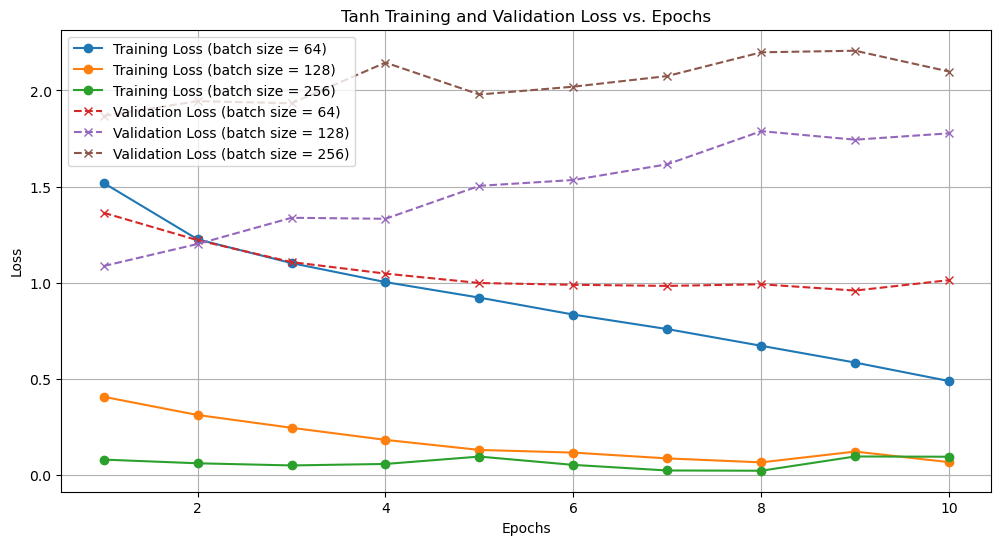

In [135]:

# Data for batch size 64
epochs_64 = list(range(1, 11))
training_loss_64 = [1.5185, 1.2249, 1.1014, 1.0025, 0.9217, 0.8336, 0.7580, 0.6711, 0.5837, 0.4875]
validation_loss_64 = [1.3632, 1.2206, 1.1068, 1.0467, 0.9979, 0.9885, 0.9828, 0.9912, 0.9585, 1.0128]

# Data for batch size 128
epochs_128 = list(range(1, 11))
training_loss_128 = [0.4057, 0.3109, 0.2444, 0.1814, 0.1291, 0.1152, 0.0850, 0.0644, 0.1206, 0.0654]
validation_loss_128 = [1.0862, 1.2009, 1.3373, 1.3320, 1.5036, 1.5339, 1.6158, 1.7880, 1.7437, 1.7769]

# Data for batch size 256
epochs_256 = list(range(1, 11))
training_loss_256 = [0.0788, 0.0596, 0.0484, 0.0562, 0.0945, 0.0512, 0.0222, 0.0209, 0.0951, 0.0937]
validation_loss_256 = [1.8676, 1.9444, 1.9331, 2.1449, 1.9789, 2.0196, 2.0749, 2.1985, 2.2067, 2.0984]

# Plotting
plt.figure(figsize=(12, 6))

# Training Loss
plt.plot(epochs_64, training_loss_64, marker='o', label='Training Loss (batch size = 64)')
plt.plot(epochs_128, training_loss_128, marker='o', label='Training Loss (batch size = 128)')
plt.plot(epochs_256, training_loss_256, marker='o', label='Training Loss (batch size = 256)')

# Validation Loss
plt.plot(epochs_64, validation_loss_64, marker='x', linestyle='--', label='Validation Loss (batch size = 64)')
plt.plot(epochs_128, validation_loss_128, marker='x', linestyle='--', label='Validation Loss (batch size = 128)')
plt.plot(epochs_256, validation_loss_256, marker='x', linestyle='--', label='Validation Loss (batch size = 256)')

plt.title('Tanh Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('tanh_batch.png')

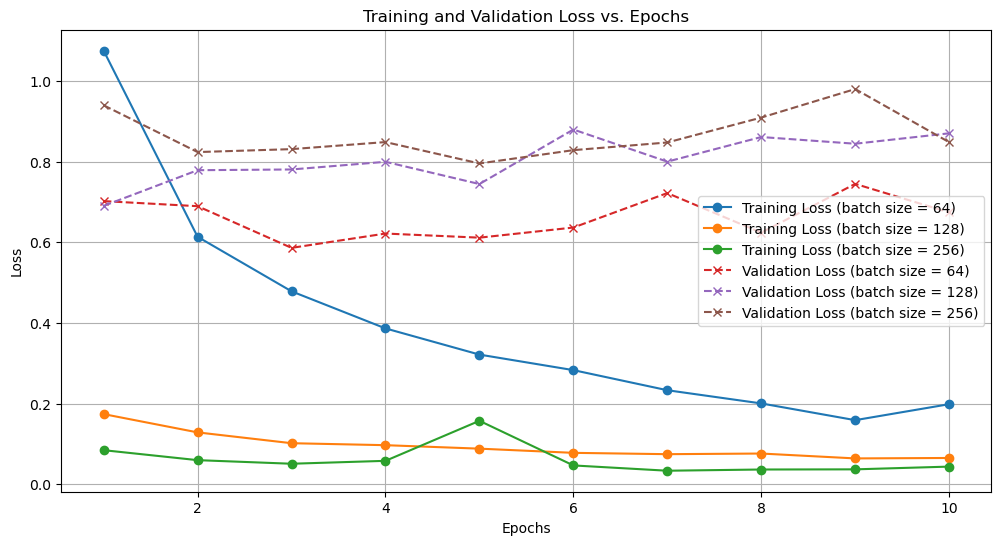

In [134]:

# Data for batch size 64
epochs_64 = list(range(1, 11))
training_loss_64 = [1.0746, 0.6134, 0.4783, 0.3864, 0.3215, 0.2830, 0.2332, 0.2005, 0.1590, 0.1986]
validation_loss_64 = [0.7019, 0.6893, 0.5860, 0.6215, 0.6113, 0.6364, 0.7218, 0.6237, 0.7446, 0.6739]

# Data for batch size 128
epochs_128 = list(range(1, 11))
training_loss_128 = [0.1740, 0.1287, 0.1019, 0.0970, 0.0884, 0.0780, 0.0747, 0.0763, 0.0642, 0.0653]
validation_loss_128 = [0.6901, 0.7785, 0.7803, 0.7993, 0.7442, 0.8793, 0.7997, 0.8607, 0.8441, 0.8699]

# Data for batch size 256
epochs_256 = list(range(1, 11))
training_loss_256 = [0.0846, 0.0599, 0.0510, 0.0582, 0.1574, 0.0468, 0.0337, 0.0367, 0.0371, 0.0439]
validation_loss_256 = [0.9393, 0.8234, 0.8307, 0.8482, 0.7952, 0.8282, 0.8472, 0.9089, 0.9796, 0.8479]

# Plotting
plt.figure(figsize=(12, 6))

# Training Loss
plt.plot(epochs_64, training_loss_64, marker='o', label='Training Loss (batch size = 64)')
plt.plot(epochs_128, training_loss_128, marker='o', label='Training Loss (batch size = 128)')
plt.plot(epochs_256, training_loss_256, marker='o', label='Training Loss (batch size = 256)')

# Validation Loss
plt.plot(epochs_64, validation_loss_64, marker='x', linestyle='--', label='Validation Loss (batch size = 64)')
plt.plot(epochs_128, validation_loss_128, marker='x', linestyle='--', label='Validation Loss (batch size = 128)')
plt.plot(epochs_256, validation_loss_256, marker='x', linestyle='--', label='Validation Loss (batch size = 256)')

plt.title('Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('google_3_batch.png')


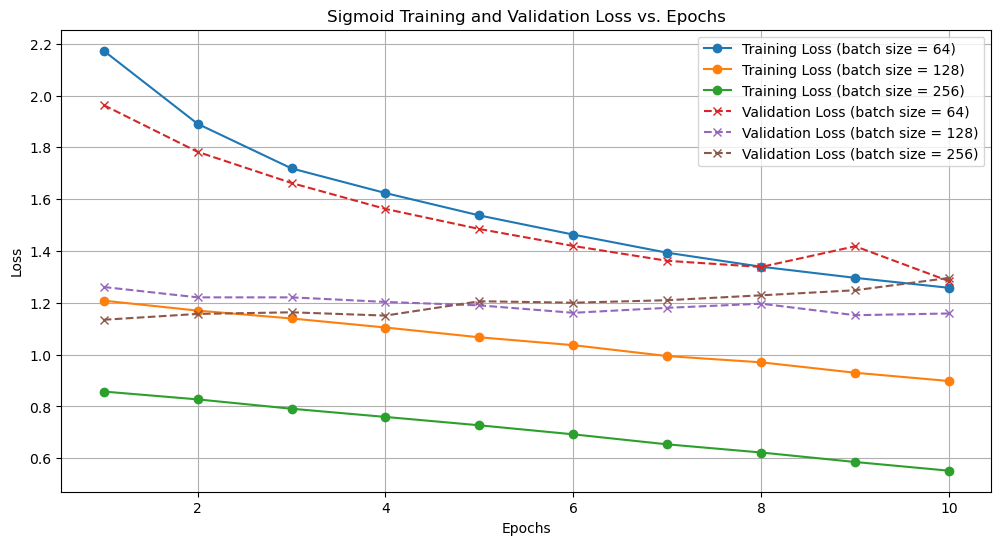

In [137]:
# Data for batch size 64
epochs_64 = list(range(1, 11))
training_loss_64 = [2.1729, 1.8907, 1.7186, 1.6235, 1.5370, 1.4631, 1.3931, 1.3391, 1.2962, 1.2577]
validation_loss_64 = [1.9630, 1.7826, 1.6623, 1.5622, 1.4847, 1.4192, 1.3619, 1.3383, 1.4181, 1.2834]

# Data for batch size 128
epochs_128 = list(range(1, 11))
training_loss_128 = [1.2082, 1.1697, 1.1394, 1.1045, 1.0667, 1.0363, 0.9942, 0.9701, 0.9298, 0.8980]
validation_loss_128 = [1.2608, 1.2209, 1.2209, 1.2032, 1.1899, 1.1613, 1.1805, 1.1964, 1.1520, 1.1587]

# Data for batch size 256
epochs_256 = list(range(1, 11))
training_loss_256 = [0.8573, 0.8271, 0.7910, 0.7593, 0.7270, 0.6921, 0.6535, 0.6220, 0.5854, 0.5517]
validation_loss_256 = [1.1344, 1.1569, 1.1632, 1.1505, 1.2059, 1.2003, 1.2099, 1.2288, 1.2483, 1.2959]

# Plotting
plt.figure(figsize=(12, 6))

# Training Loss
plt.plot(epochs_64, training_loss_64, marker='o', label='Training Loss (batch size = 64)')
plt.plot(epochs_128, training_loss_128, marker='o', label='Training Loss (batch size = 128)')
plt.plot(epochs_256, training_loss_256, marker='o', label='Training Loss (batch size = 256)')

# Validation Loss
plt.plot(epochs_64, validation_loss_64, marker='x', linestyle='--', label='Validation Loss (batch size = 64)')
plt.plot(epochs_128, validation_loss_128, marker='x', linestyle='--', label='Validation Loss (batch size = 128)')
plt.plot(epochs_256, validation_loss_256, marker='x', linestyle='--', label='Validation Loss (batch size = 256)')

plt.title('Sigmoid Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("sigmoid_3_batch")

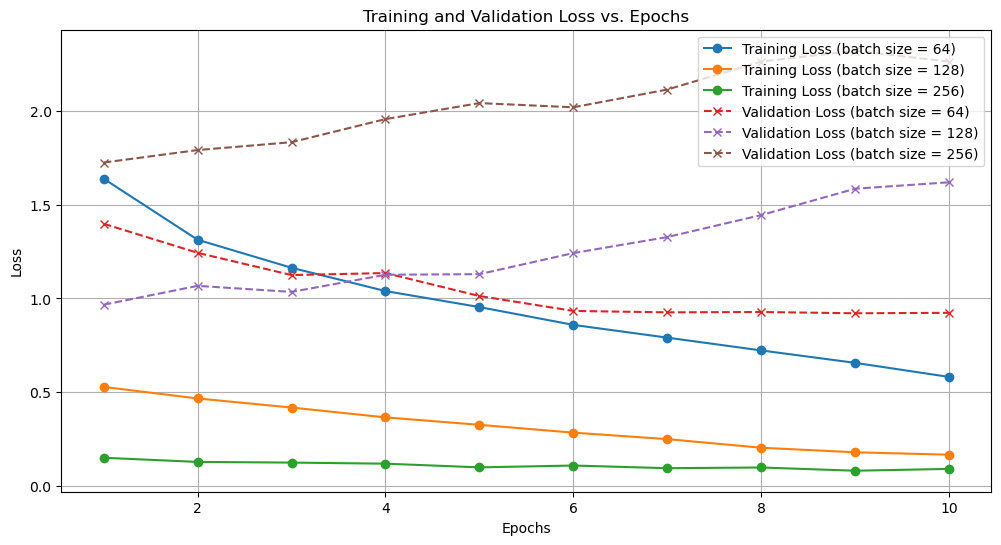

In [138]:

# Data for batch size 64
epochs_64 = list(range(1, 11))
training_loss_64 = [1.6388, 1.3130, 1.1635, 1.0393, 0.9538, 0.8588, 0.7907, 0.7225, 0.6562, 0.5812]
validation_loss_64 = [1.3983, 1.2433, 1.1246, 1.1354, 1.0128, 0.9333, 0.9257, 0.9275, 0.9208, 0.9232]

# Data for batch size 128
epochs_128 = list(range(1, 11))
training_loss_128 = [0.5280, 0.4663, 0.4178, 0.3654, 0.3257, 0.2839, 0.2494, 0.2034, 0.1792, 0.1662]
validation_loss_128 = [0.9666, 1.0670, 1.0348, 1.1263, 1.1295, 1.2419, 1.3274, 1.4448, 1.5854, 1.6196]

# Data for batch size 256
epochs_256 = list(range(1, 11))
training_loss_256 = [0.1500, 0.1278, 0.1242, 0.1184, 0.0987, 0.1085, 0.0943, 0.0980, 0.0808, 0.0905]
validation_loss_256 = [1.7249, 1.7915, 1.8335, 1.9567, 2.0421, 2.0197, 2.1144, 2.2636, 2.3215, 2.2631]

# Plotting
plt.figure(figsize=(12, 6))

# Training Loss
plt.plot(epochs_64, training_loss_64, marker='o', label='Training Loss (batch size = 64)')
plt.plot(epochs_128, training_loss_128, marker='o', label='Training Loss (batch size = 128)')
plt.plot(epochs_256, training_loss_256, marker='o', label='Training Loss (batch size = 256)')

# Validation Loss
plt.plot(epochs_64, validation_loss_64, marker='x', linestyle='--', label='Validation Loss (batch size = 64)')
plt.plot(epochs_128, validation_loss_128, marker='x', linestyle='--', label='Validation Loss (batch size = 128)')
plt.plot(epochs_256, validation_loss_256, marker='x', linestyle='--', label='Validation Loss (batch size = 256)')

plt.title('Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("relu.png")

In [ ]:
!uname -a

Linux 85dc438a0bcb 5.15.120+ #1 SMP Wed Aug 30 11:19:59 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux


In [ ]:
!nvidia-smi

Tue Oct 31 08:19:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    30W /  70W |   1245MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.2 LTS
Release:	22.04
Codename:	jammy


In [ ]:
!python -V

Python 3.10.12
